# **Panoptic Segmentation**

Panoptic segmentation is an image segmentation method used for Computer Vision tasks. It unifies two distinct concepts used to segment images namely, semantic segmentation and instance segmentation.

To read about it more, please refer [this](https://analyticsindiamag.com/guide-to-panoptic-segmentation-a-semantic-instance-segmentation-approach/) article.

## **Practical implementation of panoptic segmentation**

The following code illustrates panoptic segmentation performed on MS-COCO dataset using PyTorch Python library and Detectron2 (a PyTorch-based modular library by Facebook AI Research (FAIR) for implementing object detection algorithms and also a rewrite of Detectron library). We have also used the DETR (DEtection TRansformer) framework introduced by FAIR which views object detection as a direct set prediction problem.

Not aware of Detectron, Detectron2 and DETR ? Refer to the following links before proceeding!

> * [Detectron](https://research.fb.com/downloads/detectron/)([Github](https://github.com/facebookresearch/Detectron)) 
> * [Detectron2](https://ai.facebook.com/tools/detectron2/)([GitHub](https://github.com/facebookresearch/Detectron2))
> * [DETR Research Paper](https://arxiv.org/pdf/2005.12872.pdf)

In [ ]:
!python -m pip install pip --upgrade --user -q --no-warn-script-location
!python -m pip install numpy pandas seaborn matplotlib scipy statsmodels sklearn tensorflow keras opencv-python pillow scikit-image torch torchvision \
     tqdm --user -q --no-warn-script-location

import IPython
IPython.Application.instance().kernel.do_shutdown(True)


Import the required libraries

In [1]:
from PIL import Image
import requests
import io
import math
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
torch.set_grad_enabled(False);
import itertools
import seaborn as sns 

Install the Panoptic API from GitHub for panoptic inference

In [2]:
!python -m pip install git+https://github.com/cocodataset/panopticapi.git --user -q

  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-em242qk7
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-em242qk7
  Created wheel for panopticapi: filename=panopticapi-0.1-cp37-none-any.whl size=8306 sha256=3203a0ad2cdc3e7f730669095a0bbc35361ecabd245ddc7fb17f1e3aa7198513
  Stored in directory: /tmp/pip-ephem-wheel-cache-nabfsf7w/wheels/41/ae/17/f7e628e1ba4776ceea035aefb113ef24b6639ad5d5a2e5a5d1
Successfully built panopticapi


Import the installed API

In [3]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id 

List of COCO semantic classes:

In [4]:
CLASSES = [
     'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
     'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
     'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
     'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A',   
     'Backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 
     'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 
     'baseball glove', 'skateboard', 'surfboard', 'tennis racket',    
     'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 
     'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 
     'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 
     'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
     'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 
     'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'] 

Enumerate the above classes (Detectron2 model uses different numbering convention so we need to change it)

In [5]:
coco2d2 = {}
count = 0
for i, c in enumerate(CLASSES):
  if c != "N/A":
    coco2d2[i] = count
    count+=1 

Perform standard PyTorch mean-std input image normalization

In [6]:
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]) 

Load a pre-trained model from torch hub and request the post-processor

In [7]:
model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', pretrained=True, return_postprocessor=True, num_classes=250)
model.eval();

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-panoptic-40021d53.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-panoptic-40021d53.pth


Retrieve an image from the validation set of COCO dataset for testing purpose

In [8]:
url = "http://images.cocodataset.org/val2017/000000281759.jpg"
im = Image.open(requests.get(url, stream=True).raw)

Mean-std normalize the input testing image (batch-size: 1)

In [9]:
img = transform(im).unsqueeze(0)
out = model(img) 

Compute the probability score for each possible class, excluding the “no-object” class (the last one)

In [10]:
scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]

Threshold the confidence to only masks with high confidence >0.85

In [11]:
keep = scores > 0.85

Plot the masks satisfying the confidence level condition

In [12]:
ncols = 5
fig, axs = plt.subplots(ncols=ncols, nrows=math.ceil(keep.sum().item() / ncols), figsize=(18, 10))
for line in axs:
    for a in line:
        a.axis('off')
for i, mask in enumerate(out["pred_masks"][keep]):
    ax = axs[i // ncols, i % ncols]
    ax.imshow(mask, cmap="cividis")
    ax.axis('off')
fig.tight_layout() 

Output hidden; open in https://colab.research.google.com to view.

Merge the individual predictions obtained by running the above lines of code into a unified panoptic segmentation. For that, we use DETR’s postprocessor.

The post-processor requires as input the target size of predictions

In [13]:
result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


The segmentation is stored in a special-format png

In [14]:
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()

Retrieve the instance id corresponding to each mask

In [15]:
panoptic_seg_id = rgb2id(panoptic_seg)

Colour each mask individually and plot the visualization

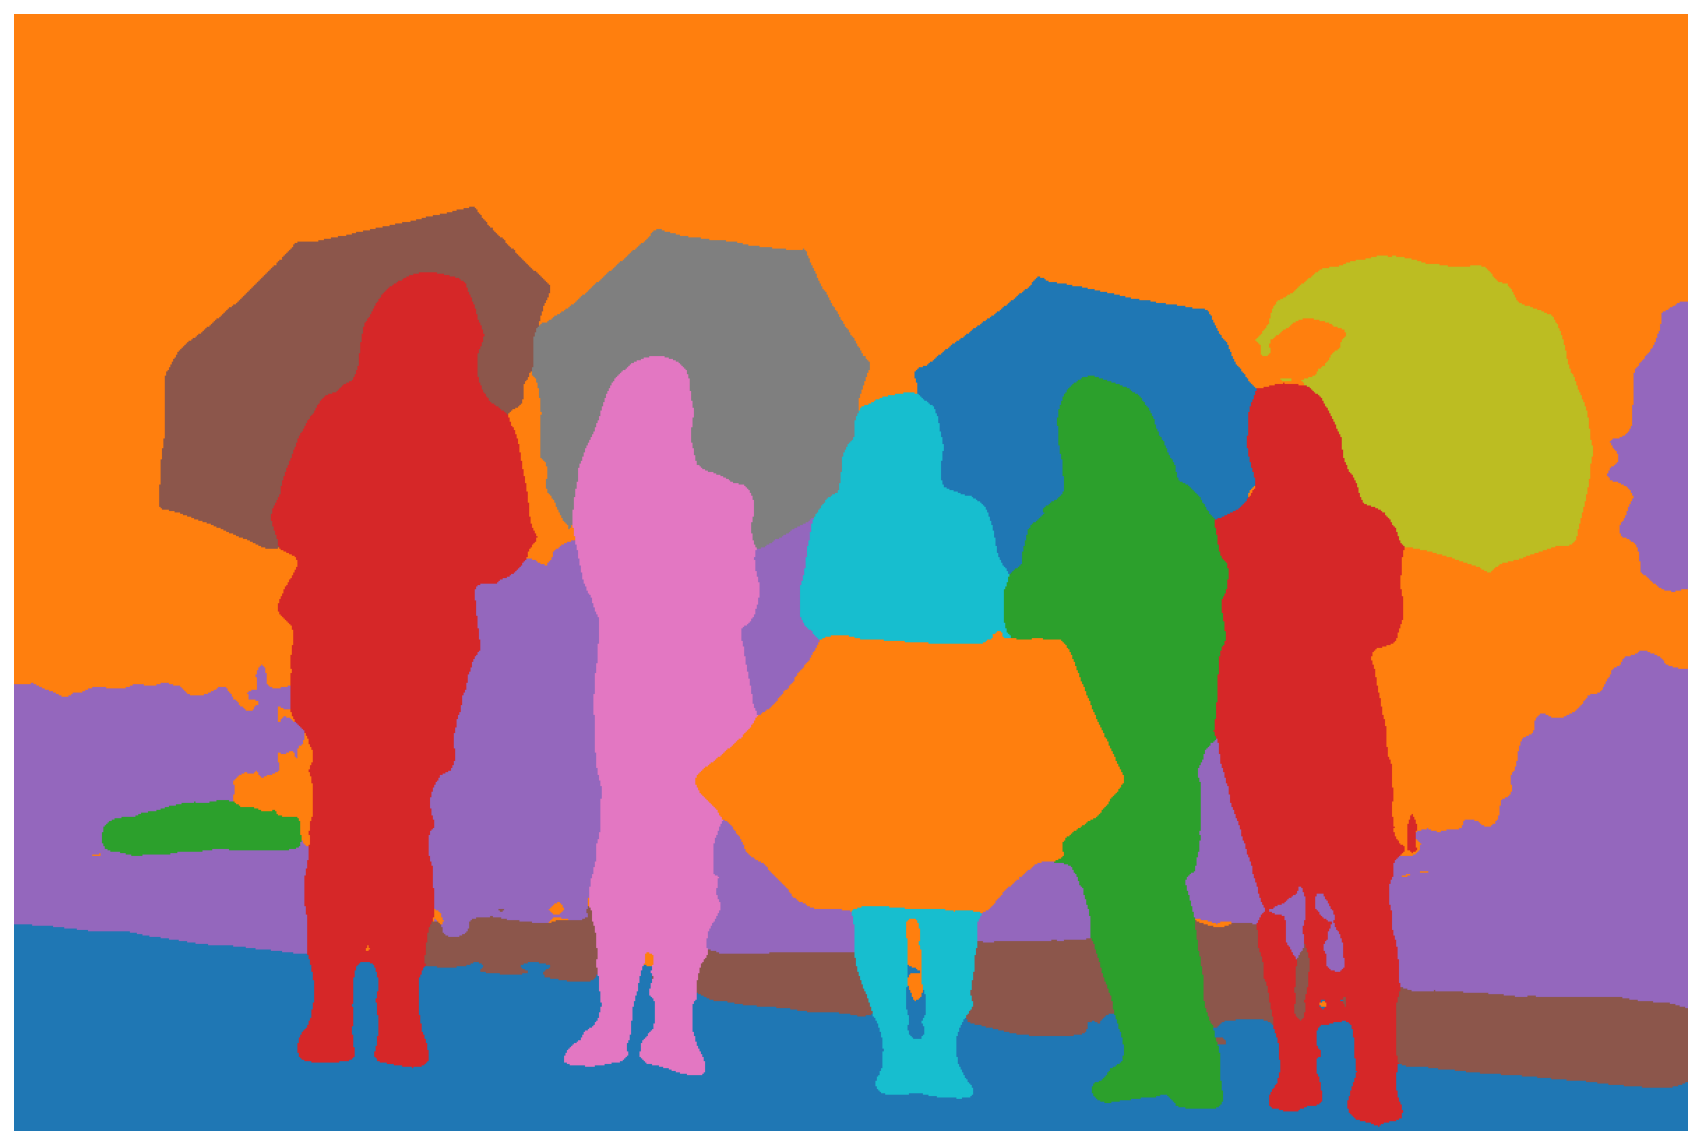

In [16]:
import itertools
import seaborn as sns
palette = itertools.cycle(sns.color_palette())
panoptic_seg[:, :, :] = 0
for id in range(panoptic_seg_id.max() + 1):
  panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255
plt.figure(figsize=(15,15))
plt.imshow(panoptic_seg)
plt.axis('off')
plt.show() 

Use Detectron2’s plotting utilities to better visualize the above panoptic segmentation results.

Import the utilities

In [17]:
# install dependencies: 
!python -m pip install pyyaml==5.1 --user -q
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 2.9MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=fe350ca3e14460aa5d2ba14f358cb24905317849b26567f9ec526371cbeaf690
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 False
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [18]:
# install detectron2:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html --user -q
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 786kB/s 
     |████████████████████████████████| 51kB 3.2MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=6760ba30b1baff341d4b0ca49c82c0dca053b25a2c7c3e7939aa20722018af39
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


In [19]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [20]:
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

Extract the segments information and the panoptic result from DETR’s prediction

In [21]:
from copy import deepcopy
segments_info = deepcopy(result["segments_info"])

Store the panoptic predictions in a special format png

In [22]:
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size 

Convert the png into segment id map

In [23]:
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

Change Detectron2’s numbering to appropriate class id’s

In [24]:
meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")
for i in range(len(segments_info)):
    c = segments_info[i]["category_id"]
    segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c] 

Visualize the improved prediction results

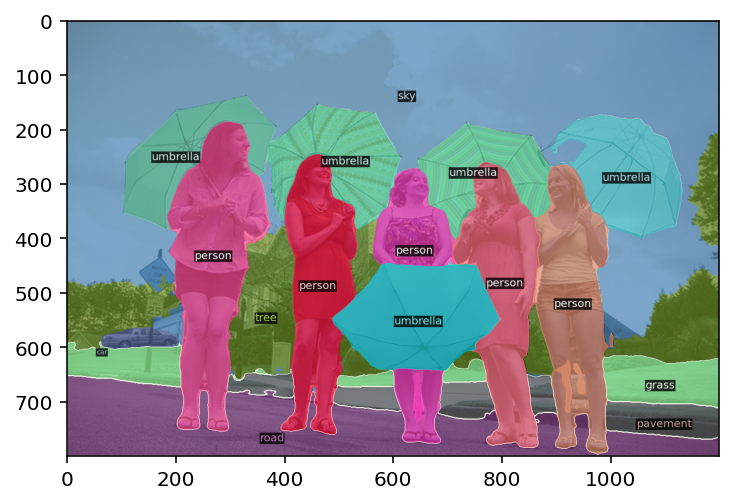

In [25]:
v = Visualizer(numpy.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
plt.imshow(v.get_image()) 
plt.show()

#**Related Articles:**

> * [Panoptic Segmentation](https://analyticsindiamag.com/guide-to-panoptic-segmentation-a-semantic-instance-segmentation-approach/)

> * [PaddleSeg](https://analyticsindiamag.com/guide-to-asymmetric-non-local-neural-networks-using-paddleseg/)

> * [MMDetection](https://analyticsindiamag.com/guide-to-mmdetection-an-object-detection-python-toolbox/)

> * [Facebook D2Go to Mobile](https://analyticsindiamag.com/facebooks-d2go-brings-detectron2-to-mobile/)

> * [Multi Class Image Classification with Tensorflow and Keras](https://analyticsindiamag.com/multi-label-image-classification-with-tensorflow-keras/)

> * [Transfer Learning in Tensorflow Keras](https://analyticsindiamag.com/a-practical-guide-to-implement-transfer-learning-in-tensorflow/)

> * [Differentiable Augmentation for Data-Efficient GAN Training](https://analyticsindiamag.com/guide-to-differentiable-augmentation-for-data-efficient-gan-training/)